In [4]:
import pandas as pd
import datetime
# !pip install pandas_datareader
import pandas_datareader.data as web
from pandas import Series,DataFrame

In [6]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019,1,1)

df = web.DataReader("AAPL",'yahoo',start,end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,145.090836
2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,155.308350
2018-12-27,156.770004,150.070007,155.839996,156.149994,53117100.0,154.300446
2018-12-28,158.520004,154.550003,157.500000,156.229996,42291400.0,154.379486
2018-12-31,159.360001,156.479996,158.529999,157.740005,35003500.0,155.871613


In [7]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

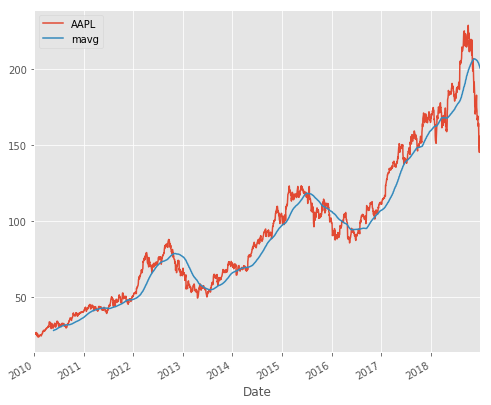

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

import matplotlib as mpl
mpl.rc('figure', figsize=(8,7))
mpl.__version__

style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

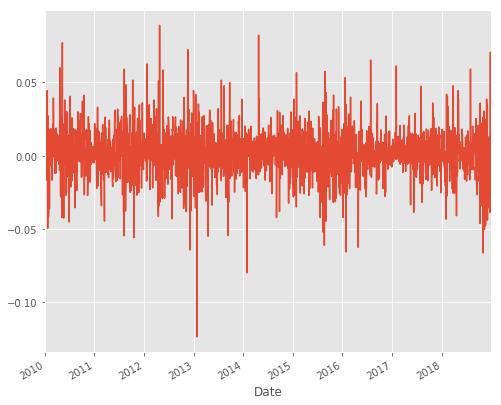

In [12]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [13]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [14]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

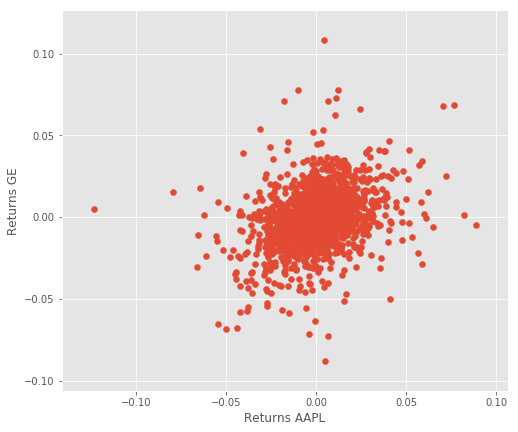

In [16]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

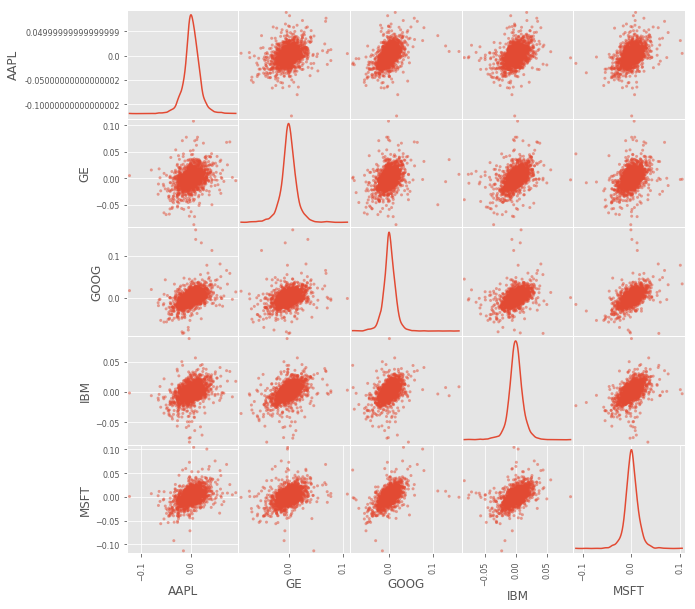

In [19]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

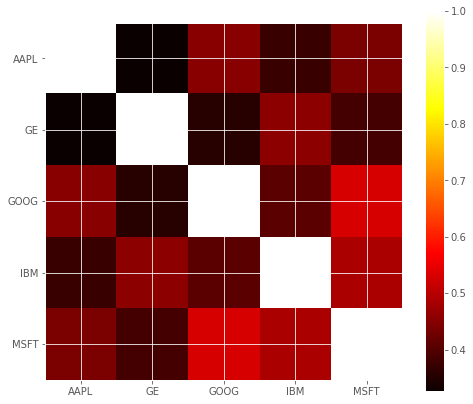

In [20]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

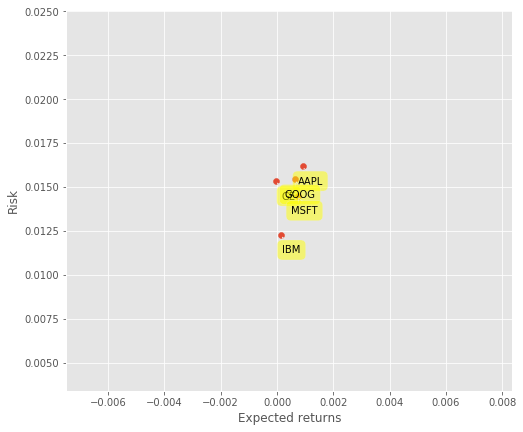

In [21]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [24]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [27]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30, random_state=0)

In [33]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [34]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [35]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
('The linear regression confidence is ', 0.96399641826551985)
('The quadratic regression 2 confidence is ', 0.96492624557970319)
('The quadratic regression 3 confidence is ', 0.9652082834532858)
('The knn regression confidence is ', 0.92844658034790639)

('The knn regression confidence is ', 0.9284465803479064)

In [42]:
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan
#result
# (array([ 115.44941187,  115.20206522,  116.78688393,  116.70244946,
#         116.58503739,  115.98769407,  116.54315699,  117.40012338,
#         117.21473053,  116.57244657,  116.048717  ,  116.26444966,
#         115.78374093,  116.50647805,  117.92064806,  118.75581186,
#         118.82688731,  119.51873699]), 0.96234891774075604, 18)

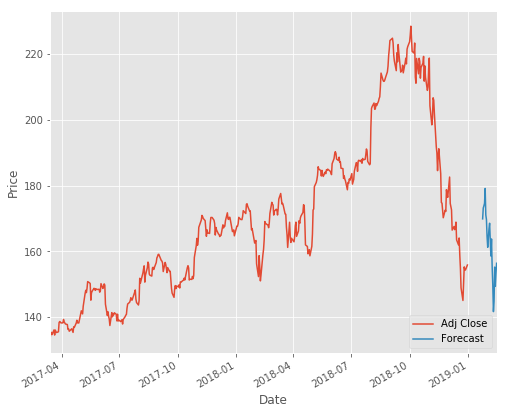

In [43]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()